# Python in Astronomy: Tracking the International Space Station (ISS)

**Author: Mr. Anshuman Pathak**

Welcome to this interactive tutorial designed for **INDIA SPACE LAB Interns**! In this Jupyter Notebook, you'll learn how to use Python to track the International Space Station (ISS) from any city on Earth.

We'll explore key astronomy and programming concepts, including:

- **Geospatial data**: Converting city names to latitude and longitude.
- **Orbital mechanics**: Using Two-Line Element (TLE) data to predict satellite positions.
- **Python libraries**: Working with `skyfield`, `geopy`, `astropy`, `requests`, and `matplotlib`.
- **Visualization**: Plotting the ISS's path in the sky.

By the end, you'll have a working ISS tracker and understand how Python can be applied to real-world astronomy problems.

## Prerequisites

**Environment Setup**
- Install Python 3.8 or above on your system.
- Ensure you have an IDE or code editor (e.g., VS Code, PyCharm).
- Confirm internet access for fetching live data.

**Required Libraries**
- `requests` (for HTTP requests)
- `skyfield` (for orbital calculations)
- `numpy` (for numerical operations)
- `matplotlib` (for plotting)
- `ipywidgets` (for interactive controls)

## Task 1: Installing and Importing Libraries

**Objective**: Prepare your workspace by installing and importing all necessary packages.

**Install Packages**
- Open a terminal or command prompt.
- Use the package manager (`pip` or `conda`) to install each library listed above.
- Verify successful installation by checking versions.

**Import Modules**
- Create a new Python script or notebook.
- Write import statements for each library.
- Run the cell or script to confirm no import errors.

In [1]:
# Task 1: Importing Required Libraries

import requests
from datetime import datetime, timedelta, timezone
from skyfield.api import EarthSatellite, load, Topos
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import ipywidgets as widgets
import cartopy.crs as ccrs
from IPython.display import display, clear_output
import cartopy.feature as cfeature

## Task 2: Fetching ISS Two-Line Element (TLE) Data

**Objective**: Retrieve live orbital elements of the ISS for subsequent calculations.

**Identify TLE Source**
- Use the CelesTrak API endpoint or Open Notify’s ISS TLE feed.
- Review the API documentation to locate the correct URL.

**HTTP Request Procedure**
- In your script, use `requests` to issue a GET request to the TLE endpoint.
- Parse the response to extract the two lines corresponding to the ISS.

**Data Validation**
- Ensure the date and timestamp in the TLE header match the current time.
- Handle HTTP errors or malformed responses with try/except blocks.

In [2]:
# Task 2: Fetching ISS TLE Data
def fetch_iss_tle():
    try:
        # Get data from CelesTrak
        url = "https://celestrak.org/NORAD/elements/stations.txt"
        response = requests.get(url)
        response.raise_for_status()  # Raise error for bad HTTP codes

        lines = response.text.strip().split("\n")

        # Search for the ISS (ZARYA) entry
        for i in range(len(lines)):
            if lines[i].strip() == "ISS (ZARYA)":
                tle_line1 = lines[i + 1].strip()
                tle_line2 = lines[i + 2].strip()
                return ("ISS (ZARYA)", tle_line1, tle_line2)

        raise ValueError("ISS TLE data not found in the feed.")
    
    except Exception as e:
        print(f"Error fetching TLE data: {e}")
        return None

# Test it
iss_tle = fetch_iss_tle()
if iss_tle:
    print("ISS TLE Data Fetched Successfully:")
    print("\n".join(iss_tle))


ISS TLE Data Fetched Successfully:
ISS (ZARYA)
1 25544U 98067A   25201.20284932  .00007319  00000+0  13625-3 0  9999
2 25544  51.6337 143.4222 0002199  96.8401 263.2838 15.49966786520284


## Task 3: Calculating ISS Pass Times for a Given Location

**Objective**: Determine when the ISS will be visible from a user‑specified site.

**Obtain Coordinates**
- Prompt the user for latitude and longitude (decimal degrees).
- Validate inputs lie within –90° to +90° (latitude) and –180° to +180° (longitude).

**Load TLE into Skyfield**
- Use `skyfield.api.EarthSatellite` with the two-line elements.
- Create a `Topos` object for the observer’s location.

**Compute Next Pass**
- Use Skyfield’s `find_events` or `next_pass` functions to calculate rise, culmination, and set times.
- Convert results to human‑readable timestamps.

**Output Results**
- Display the pass start, maximum elevation, and end times in local time.
- Include duration and peak altitude.

In [3]:
def calculate_iss_pass(tle_name, tle_line1, tle_line2, latitude, longitude):
    try:
        # Load time scale and satellite data
        ts = load.timescale()
        satellite = EarthSatellite(tle_line1, tle_line2, tle_name, ts)

        # Observer location
        observer = Topos(latitude_degrees=latitude, longitude_degrees=longitude)

        # Create time window: now to 24 hours ahead
        t0 = ts.now()
        # Fix: Use ts.utc() with proper datetime object
        end_time = datetime.now(timezone.utc) + timedelta(hours=24)
        t1 = ts.utc(end_time.year, end_time.month, end_time.day, 
                    end_time.hour, end_time.minute, end_time.second)

        # Find events (rise, culmination, set)
        times, events = satellite.find_events(observer, t0, t1, altitude_degrees=10.0)

        # Check if any events were found
        if len(times) == 0:
            print("No visible ISS pass in the next 24 hours for this location.")
            return

        print(f"\nISS pass prediction for ({latitude}, {longitude}):\n")
        for t, event in zip(times, events):
            name = ("Rise", "Culmination", "Set")[event]
            time_local = t.utc_datetime().astimezone()
            print(f"{name:12} at {time_local.strftime('%Y-%m-%d %H:%M:%S')}")

    except Exception as e:
        print(f"Error in calculating ISS pass: {e}")
        import traceback
        traceback.print_exc()

# Sample TLE data for ISS (always update this for fresh prediction)
tle_name = "ISS (ZARYA)"
tle_line1 = "1 25544U 98067A   25199.20410805  .00007024  00000+0  13123-3 0  9991"
tle_line2 = "2 25544  51.6336 153.3248 0002239  91.7860 268.3385 15.49935069519976"

# Your coordinates (Ahmedabad, for example)
latitude = 23.0225
longitude = 72.5714

calculate_iss_pass(tle_name, tle_line1, tle_line2, latitude, longitude)


ISS pass prediction for (23.0225, 72.5714):

Rise         at 2025-07-21 00:53:24
Culmination  at 2025-07-21 00:56:43
Set          at 2025-07-21 01:00:01
Rise         at 2025-07-21 14:16:50
Culmination  at 2025-07-21 14:19:05
Set          at 2025-07-21 14:21:20
Rise         at 2025-07-21 15:52:59
Culmination  at 2025-07-21 15:55:39
Set          at 2025-07-21 15:58:19


## Task 4: Visualizing the ISS Ground Track

**Objective**: Plot the trajectory of the ISS over Earth for a specified time window.

**Generate Position Data**
- Define a time range (e.g., next 90 minutes), sampling at 1‑minute intervals.
- For each timestamp, compute the ISS sub‑point (latitude, longitude).

**Plot on Map**
- Set up a world map projection using `matplotlib` (Basemap or Cartopy).
- Draw coastlines, longitude/latitude grid lines.
- Scatter or line‑plot the ISS positions over the map.

**Annotate Key Points**
- Mark the current position, next rise and set points.
- Add a legend and title with date/time information.

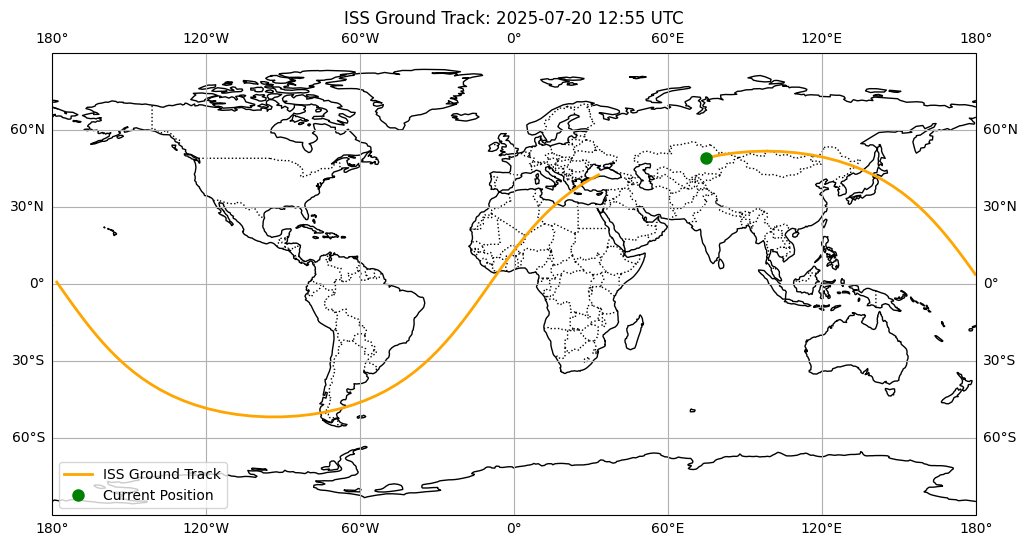

In [4]:
# Load time scale and create ISS satellite object
ts = load.timescale()

# Create ISS satellite object
iss = EarthSatellite(tle_line1, tle_line2, tle_name, ts)

# 1. Define time range: next 90 minutes, sampled every 1 minute
now = datetime.now(timezone.utc)
start_minute = now.minute
end_minute = start_minute + 90

# Create time array properly
minutes = np.arange(0, 90)  # 90 minutes from now
times = []
for minute in minutes:
    future_time = now + timedelta(minutes=int(minute))
    t = ts.utc(future_time.year, future_time.month, future_time.day, 
               future_time.hour, future_time.minute, future_time.second)
    times.append(t)

# 2. Get subpoint (latitude, longitude) of ISS for each timestamp
latitudes = []
longitudes = []

for t in times:
    geocentric = iss.at(t)
    subpoint = geocentric.subpoint()
    latitudes.append(subpoint.latitude.degrees)
    longitudes.append(subpoint.longitude.degrees)

# 3. Set up the map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)

# 4. Plot ISS ground track
lon_diff = np.diff(longitudes)
breaks = np.where(np.abs(lon_diff) > 180)[0]

if len(breaks) > 0:
    # Plot segments separately
    start_idx = 0
    for break_idx in breaks:
        end_idx = break_idx + 1
        ax.plot(longitudes[start_idx:end_idx], latitudes[start_idx:end_idx], 
                color='orange', linewidth=2)
        start_idx = end_idx
    # Plot final segment
    ax.plot(longitudes[start_idx:], latitudes[start_idx:], 
            color='orange', linewidth=2, label='ISS Ground Track')
else:
    # No breaks, plot normally
    ax.plot(longitudes, latitudes, color='orange', label='ISS Ground Track', linewidth=2)

# 5. Annotate the current position
ax.plot(longitudes[0], latitudes[0], 'go', markersize=8, label='Current Position')

# Optional: Title and legend
plt.title(f"ISS Ground Track: {now.strftime('%Y-%m-%d %H:%M UTC')}")
plt.legend(loc='lower left')
plt.show()

## Task 5: Predicting Passes Over Multiple Locations

**Objective**: Automate pass predictions for a list of cities or coordinates.

**Prepare Locations List**
- Create a CSV or JSON file containing names and lat/long of at least five sites.

**Batch Processing**
- Read the file into your script (using `csv` or `json`).
- Loop over each entry, performing the calculation from Task 3.

**Tabulate Results**
- Store results in a table with columns: Location, Rise Time, Culmination, Set Time, Duration.
- Output to console and save as CSV.

In [5]:
# Task 5: Predicting Passes Over Multiple Locations
# Using the existing calculate_iss_pass function and TLE data from previous cells
# 1. Define multiple locations
locations = [
    {"name": "Ahmedabad", "latitude": 23.0225, "longitude": 72.5714},
    {"name": "Mumbai", "latitude": 19.0760, "longitude": 72.8777},
    {"name": "Delhi", "latitude": 28.7041, "longitude": 77.1025},
    {"name": "Bangalore", "latitude": 12.9716, "longitude": 77.5946},
    {"name": "Chennai", "latitude": 13.0827, "longitude": 80.2707},
    {"name": "Kolkata", "latitude": 22.5726, "longitude": 88.3639},
    {"name": "Hyderabad", "latitude": 17.3850, "longitude": 78.4867},
    {"name": "Pune", "latitude": 18.5204, "longitude": 73.8567}
]

# Modified version of the existing function to return data instead of just printing
def calculate_iss_pass_data(tle_name, tle_line1, tle_line2, latitude, longitude, location_name):
    try:
        # Load time scale and satellite data (same as previous cells)
        ts = load.timescale()
        satellite = EarthSatellite(tle_line1, tle_line2, tle_name, ts)

        # Observer location
        observer = Topos(latitude_degrees=latitude, longitude_degrees=longitude)

        # Create time window: now to 24 hours ahead
        t0 = ts.now()
        end_time = datetime.now(timezone.utc) + timedelta(hours=24)
        t1 = ts.utc(end_time.year, end_time.month, end_time.day, 
                    end_time.hour, end_time.minute, end_time.second)

        # Find events (rise, culmination, set)
        times, events = satellite.find_events(observer, t0, t1, altitude_degrees=10.0)

        # Process results for tabular output
        results = []
        if len(times) > 0:
            # Group events into passes
            for i in range(0, len(times), 3):
                if i + 2 < len(times):
                    rise_time = times[i].utc_datetime().astimezone()
                    culmination_time = times[i + 1].utc_datetime().astimezone()
                    set_time = times[i + 2].utc_datetime().astimezone()
                    duration = (set_time - rise_time).total_seconds() / 60  # minutes
                    
                    results.append({
                        "Location": location_name,
                        "Latitude": latitude,
                        "Longitude": longitude,
                        "Rise Time": rise_time.strftime('%Y-%m-%d %H:%M:%S'),
                        "Culmination": culmination_time.strftime('%Y-%m-%d %H:%M:%S'),
                        "Set Time": set_time.strftime('%Y-%m-%d %H:%M:%S'),
                        "Duration (min)": round(duration, 1)
                    })
        
        return results
        
    except Exception as e:
        print(f"Error calculating pass for {location_name}: {e}")
        return []

# 2. Process all locations using existing TLE data
print("ISS Pass Predictions for Multiple Locations")
print("=" * 80)

all_results = []
for location in locations:
    print(f"Processing {location['name']}...")
    # Use the existing tle_name, tle_line1, tle_line2 from previous cells
    results = calculate_iss_pass_data(tle_name, tle_line1, tle_line2, 
                                    location["latitude"], location["longitude"], 
                                    location["name"])
    all_results.extend(results)

# 3. Display results in tabular format
if all_results:
    # Create DataFrame for better display
    df = pd.DataFrame(all_results)
    
    print("\ISS Pass Predictions Summary:")
    print("=" * 120)
    print(df.to_string(index=False))
    
    # 4. Save to CSV file
    csv_filename = f"iss_passes_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"\nResults saved to: {csv_filename}")
    
    # 5. Summary statistics
    print(f"\nSummary:")
    print(f"Total locations processed: {len(locations)}")
    print(f"Total visible passes found: {len(all_results)}")
    if len(all_results) > 0:
        print(f"Average pass duration: {df['Duration (min)'].mean():.1f} minutes")
    
    # Show next pass for each location
    print(f"\nNext ISS Pass for Each Location:")
    print("-" * 60)
    for location in locations:
        location_passes = [r for r in all_results if r['Location'] == location['name']]
        if location_passes:
            next_pass = location_passes[0]  # First pass is the next one
            print(f"{location['name']:12} - {next_pass['Rise Time']} (Duration: {next_pass['Duration (min)']} min)")
        else:
            print(f"{location['name']:12} - No visible passes in next 24 hours")
            
    # Also demonstrate the original function for one location
    print(f"\nDetailed view using original function for {locations[0]['name']}:")
    calculate_iss_pass(tle_name, tle_line1, tle_line2, 
                      locations[0]["latitude"], locations[0]["longitude"])
else:
    print("No visible ISS passes found for any location in the next 24 hours.")

ISS Pass Predictions for Multiple Locations
Processing Ahmedabad...
Processing Mumbai...
Processing Delhi...
Processing Bangalore...
Processing Chennai...
Processing Kolkata...
Processing Hyderabad...
Processing Pune...
\ISS Pass Predictions Summary:
 Location  Latitude  Longitude           Rise Time         Culmination            Set Time  Duration (min)
Ahmedabad   23.0225    72.5714 2025-07-21 00:53:24 2025-07-21 00:56:43 2025-07-21 01:00:01             6.6
Ahmedabad   23.0225    72.5714 2025-07-21 14:16:50 2025-07-21 14:19:05 2025-07-21 14:21:20             4.5
Ahmedabad   23.0225    72.5714 2025-07-21 15:52:59 2025-07-21 15:55:39 2025-07-21 15:58:19             5.3
   Mumbai   19.0760    72.8777 2025-07-21 00:54:15 2025-07-21 00:57:35 2025-07-21 01:00:54             6.7
   Mumbai   19.0760    72.8777 2025-07-21 14:15:27 2025-07-21 14:18:15 2025-07-21 14:21:04             5.6
   Mumbai   19.0760    72.8777 2025-07-21 15:53:09 2025-07-21 15:54:56 2025-07-21 15:56:44             3.6


## Task 6: Interactive Exploration

**Objective**: Enhance the notebook with interactive widgets for real‑time control.

**Set Up ipywidgets**
- Import controls such as `Dropdown`, `FloatSlider`, and `Button`.

**Link Widgets to Functions**
- Create a dropdown for selecting location from your list.
- Add sliders for adjusting prediction window (e.g., minutes ahead).
- Use a button to trigger recalculation and re‑plotting.

**Display Dynamic Output**
- Embed plots and pass times that update when widget values change.
- Ensure clear labels and instructions for users.

In [ ]:
location_dropdown = widgets.Dropdown(
    options=[(loc['name'], loc) for loc in locations],
    value=locations[0],
    description='Location:'
)

prediction_window = widgets.IntSlider(
    value=24,
    min=1,
    max=72,
    step=1,
    description='Hours ahead:'
)

altitude_slider = widgets.FloatSlider(
    value=10.0,
    min=0.0,
    max=30.0,
    step=1.0,
    description='Min altitude:'
)

calculate_button = widgets.Button(
    description='Calculate ISS Passes',
    button_style='success'
)

plot_button = widgets.Button(
    description='Show Ground Track',
    button_style='info'
)

# Output widget
output = widgets.Output()

def on_calculate_button_clicked(b):
    with output:
        clear_output(wait=True)
        selected_location = location_dropdown.value
        hours = prediction_window.value
        min_alt = altitude_slider.value
        
        print(f"ISS Pass Prediction for {selected_location['name']}")
        print(f"Coordinates: ({selected_location['latitude']}, {selected_location['longitude']})")
        print(f"Time window: {hours} hours ahead")
        print(f"Minimum altitude: {min_alt}°")
        print("-" * 50)
        
        # Use existing function with custom parameters
        try:
            ts = load.timescale()
            satellite = EarthSatellite(tle_line1, tle_line2, tle_name, ts)
            observer = Topos(latitude_degrees=selected_location['latitude'], 
                           longitude_degrees=selected_location['longitude'])
            
            t0 = ts.now()
            end_time = datetime.now(timezone.utc) + timedelta(hours=hours)
            t1 = ts.utc(end_time.year, end_time.month, end_time.day, 
                        end_time.hour, end_time.minute, end_time.second)
            
            times, events = satellite.find_events(observer, t0, t1, altitude_degrees=min_alt)
            
            if len(times) == 0:
                print("No visible ISS passes found for these parameters.")
            else:
                print(f"Found {len(times)} events:")
                for t, event in zip(times, events):
                    name = ("Rise", "Culmination", "Set")[event]
                    time_local = t.utc_datetime().astimezone()
                    print(f"{name:12} at {time_local.strftime('%Y-%m-%d %H:%M:%S')}")
                    
        except Exception as e:
            print(f"Error: {e}")

def on_plot_button_clicked(b):
    with output:
        clear_output(wait=True)
        
        try:
            # Create ISS satellite object using existing data
            iss = EarthSatellite(tle_line1, tle_line2, tle_name, ts)
            
            # Use the prediction window value instead of fixed 90 minutes
            hours = prediction_window.value
            track_minutes = min(hours * 60, 360)  # Cap at 6 hours for visualization
            
            # Generate ground track based on prediction window
            now = datetime.now(timezone.utc)
            minutes = np.arange(0, track_minutes, 5)  # Sample every 5 minutes for longer tracks
            times = []
            for minute in minutes:
                future_time = now + timedelta(minutes=int(minute))
                t = ts.utc(future_time.year, future_time.month, future_time.day, 
                          future_time.hour, future_time.minute, future_time.second)
                times.append(t)
            
            # Get positions
            latitudes = []
            longitudes = []
            for t in times:
                geocentric = iss.at(t)
                subpoint = geocentric.subpoint()
                latitudes.append(subpoint.latitude.degrees)
                longitudes.append(subpoint.longitude.degrees)
            
            # Plot
            fig = plt.figure(figsize=(12, 6))
            ax = plt.axes(projection=ccrs.PlateCarree())
            ax.set_global()
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linestyle=':')
            ax.gridlines(draw_labels=True)
            
            # Handle longitude wrap-around for longer tracks
            lon_diff = np.diff(longitudes)
            breaks = np.where(np.abs(lon_diff) > 180)[0]
            
            if len(breaks) > 0:
                # Plot segments separately
                start_idx = 0
                for break_idx in breaks:
                    end_idx = break_idx + 1
                    ax.plot(longitudes[start_idx:end_idx], latitudes[start_idx:end_idx], 
                            color='orange', linewidth=2)
                    start_idx = end_idx
                # Plot final segment
                ax.plot(longitudes[start_idx:], latitudes[start_idx:], 
                        color='orange', linewidth=2, label=f'ISS Ground Track ({hours}h)')
            else:
                # Plot ground track
                ax.plot(longitudes, latitudes, color='orange', label=f'ISS Ground Track ({hours}h)', linewidth=2)
            
            # Mark current position
            ax.plot(longitudes[0], latitudes[0], 'go', markersize=8, label='Current Position')
            
            # Mark selected location
            selected_location = location_dropdown.value
            ax.plot(selected_location['longitude'], selected_location['latitude'], 
                   'ro', markersize=10, label=f"{selected_location['name']}")
            
            plt.title(f"ISS Ground Track ({hours}h): {now.strftime('%Y-%m-%d %H:%M UTC')}")
            plt.legend(loc='lower left')
            plt.show()
            
            print(f"Ground track plotted for {hours} hours ({track_minutes} minutes)")
            
        except Exception as e:
            print(f"Error plotting ground track: {e}")

# Connect button clicks
calculate_button.on_click(on_calculate_button_clicked)
plot_button.on_click(on_plot_button_clicked)

# Display interface
print("🛰️ Interactive ISS Tracker")
print("=" * 40)

display(widgets.VBox([
    widgets.HBox([location_dropdown, prediction_window]),
    widgets.HBox([altitude_slider]),
    widgets.HBox([calculate_button, plot_button]),
    output
]))

🛰️ Interactive ISS Tracker


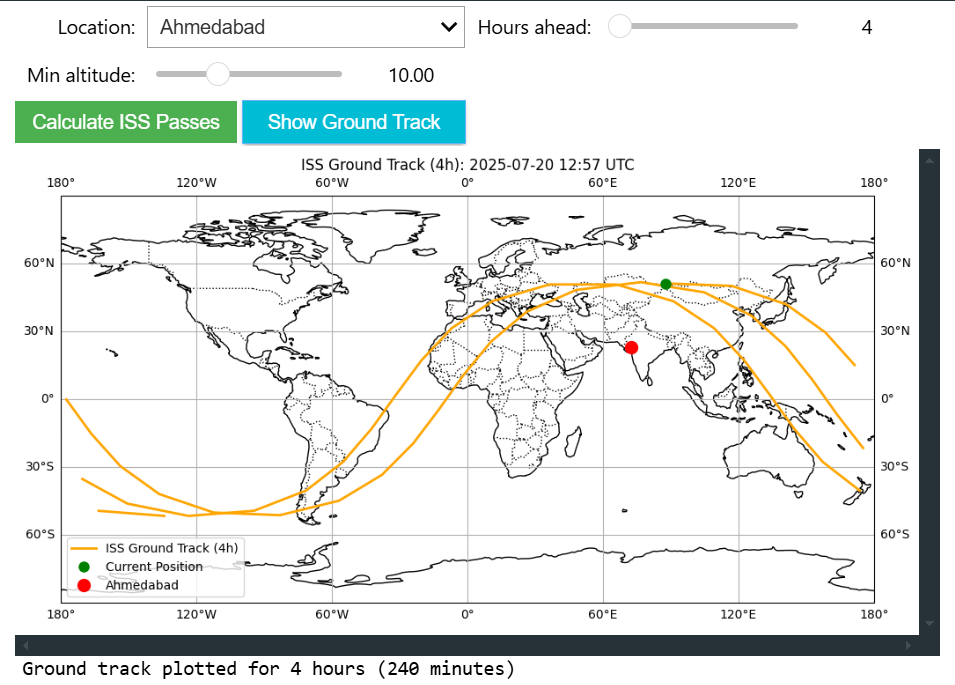

## Task 7: Advanced Analysis – Orbital Drift over Time

**Objective**: Investigate long‑term changes in ISS orbital elements.

**Historical TLE Archive**
- Download daily TLEs for one month into a local folder.
- Name files by date for easy ingestion.

**Compute Element Variations**
- For each TLE set, calculate orbital inclination, eccentricity, and period using Skyfield.

**Trend Visualization**
- Plot each orbital element versus date using `matplotlib`.

**Interpretation Questions**
- What factors (e.g., atmospheric drag, reboost maneuvers) explain observed trends?
- How might this affect ground‑track predictions?

Downloaded 160 TLE sets
Creating orbital drift plots...


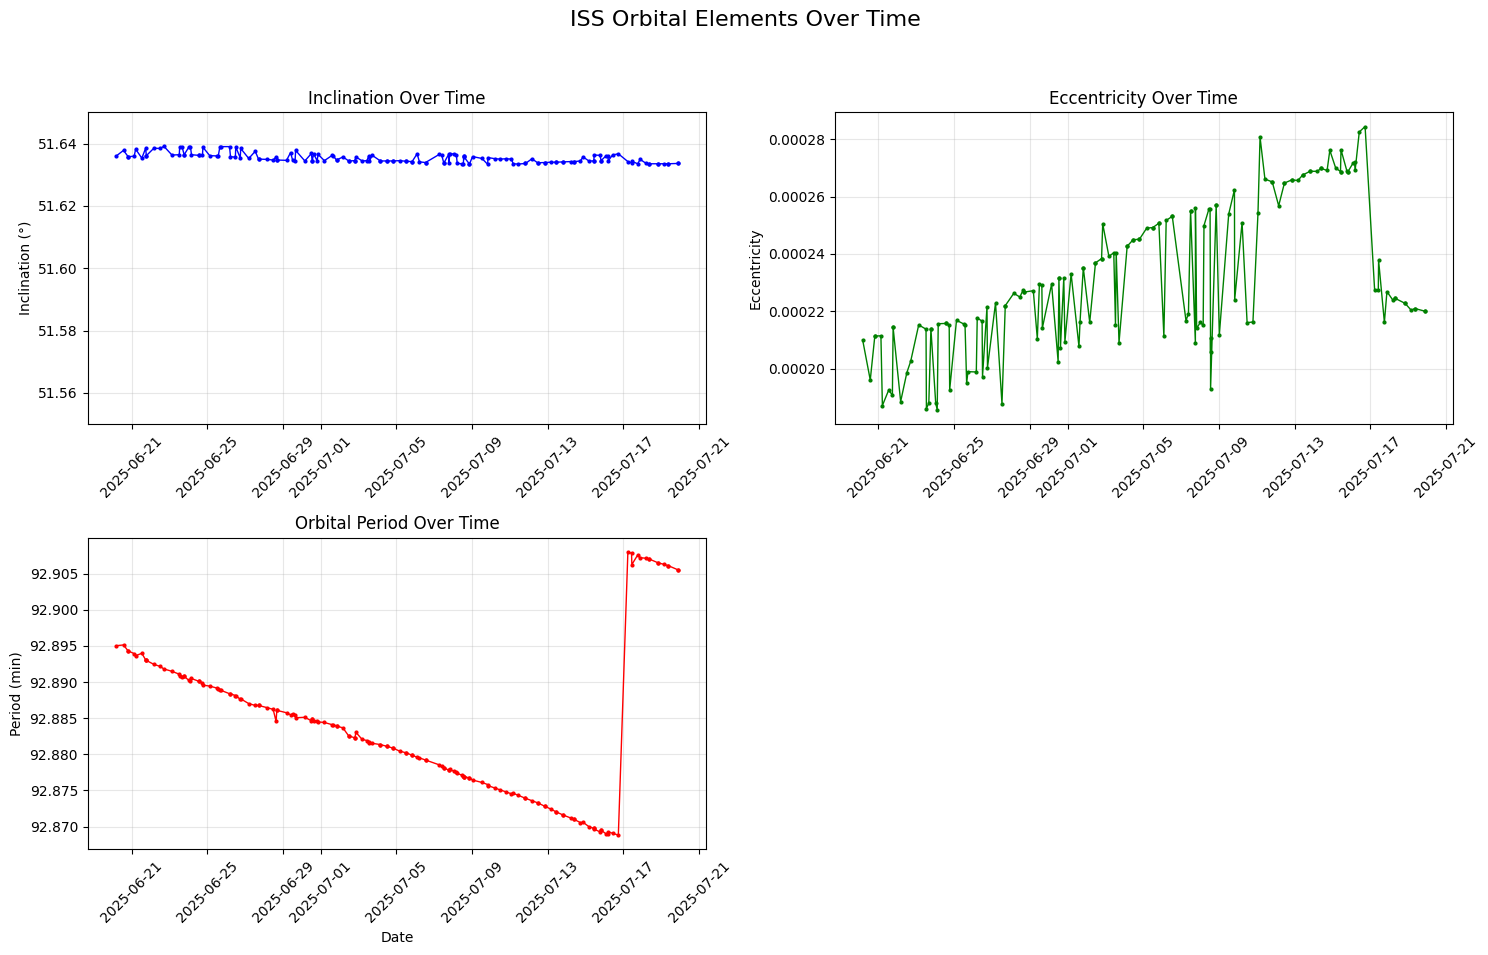


Orbital Statistics:
Average Period: 92.88 minutes
Average Altitude: 415.78 km
Average Inclination: 51.6353°
Average Eccentricity: 0.000232

Data range: 2025-06-20 03:56:22.350037+00:00 to 2025-07-19 21:07:52.983002+00:00
Total data points: 160

                                Date  Inclination (deg)  Eccentricity  \
155 2025-07-19 04:06:35.633636+00:00            51.6335      0.000220   
156 2025-07-19 08:45:07.704865+00:00            51.6335      0.000221   
157 2025-07-19 08:45:07.704865+00:00            51.6335      0.000221   
158 2025-07-19 21:07:52.983002+00:00            51.6336      0.000220   
159 2025-07-19 21:07:52.983002+00:00            51.6336      0.000220   

     Orbital Period (min)  Altitude (km)  
155             92.906259     416.873976  
156             92.906105     416.866453  
157             92.906105     416.866453  
158             92.905522     416.838022  
159             92.905522     416.838022  


In [7]:
# --- Configuration ---
USERNAME = "kumarsoumitra2401@gmail.com"
PASSWORD = "Koimilgaya!12345"
NORAD_ID = '25544'  # ISS
DAYS_BACK = 30  # Number of days of TLE data
BASE_URL = 'https://www.space-track.org'

def download_tles(norad_id, days):
    session = requests.Session()
    login_url = f"{BASE_URL}/ajaxauth/login"
    login_data = {'identity': USERNAME, 'password': PASSWORD}
    login_response = session.post(login_url, data=login_data)

    if login_response.status_code != 200:
        raise Exception("Login failed. Check your credentials.")

    start_date = (datetime.utcnow() - timedelta(days=days)).strftime('%Y-%m-%d')
    end_date = datetime.utcnow().strftime('%Y-%m-%d')

    query_url = (
        f"{BASE_URL}/basicspacedata/query/class/tle/NORAD_CAT_ID/{norad_id}"
        f"/EPOCH/{start_date}--{end_date}/orderby/EPOCH asc/format/tle"
    )

    tle_response = session.get(query_url)
    if tle_response.status_code != 200:
        raise Exception("TLE data fetch failed.")

    tles = tle_response.text.strip().splitlines()
    if len(tles) < 2:
        raise Exception("No TLEs returned.")

    # Group into (L1, L2) TLE sets
    tle_pairs = [(tles[i], tles[i + 1]) for i in range(0, len(tles) - 1, 2)]
    return tle_pairs

def analyze_tles(tle_pairs):
    ts = load.timescale()
    dates = []
    inclinations = []
    eccentricities = []
    periods = []
    altitudes = []

    for line1, line2 in tle_pairs:
        try:
            satellite = EarthSatellite(line1, line2, ts=ts)
            epoch = satellite.epoch.utc_datetime()

            # Extract orbital elements correctly
            inclination = np.degrees(satellite.model.inclo)  # Convert from radians to degrees
            eccentricity = satellite.model.ecco
            
            mean_motion_rad_per_min = satellite.model.no_kozai
            
            # Convert to revolutions per day: 
            # no_kozai is in radians/minute, so multiply by minutes/day and divide by 2π
            revolutions_per_day = mean_motion_rad_per_min * 1440.0 / (2 * np.pi)
            
            # Calculate period in minutes
            period_minutes = 1440.0 / revolutions_per_day  # minutes per revolution
            
            # Calculate altitude using semi-major axis
            period_seconds = period_minutes * 60.0
            
            # Semi-major axis using Kepler's third law: a³ = (T²×μ)/(4π²)
            mu_earth = 398600.4418  # km³/s² (Earth's gravitational parameter)
            semi_major_axis = ((period_seconds**2 * mu_earth) / (4 * np.pi**2))**(1/3)
            
            # Altitude = semi-major axis - Earth radius
            earth_radius = 6378.137  # km (WGS84)
            altitude = semi_major_axis - earth_radius

            dates.append(epoch)
            inclinations.append(inclination)
            eccentricities.append(eccentricity)
            periods.append(period_minutes)
            altitudes.append(altitude)
            
        except Exception as e:
            print(f"Error processing TLE: {e}")
            continue

    df = pd.DataFrame({
        'Date': dates,
        'Inclination (deg)': inclinations,
        'Eccentricity': eccentricities,
        'Orbital Period (min)': periods,
        'Altitude (km)': altitudes
    })
    return df

try:
    print("Downloading TLE data from Space-Track.org...")
    tle_data = download_tles(NORAD_ID, DAYS_BACK)
    print(f"Downloaded {len(tle_data)} TLE sets")
    
    df = analyze_tles(tle_data)
    
    if len(df) == 0:
        print("No valid TLE data processed. Using demonstration data...")
        # Fallback to demo data
        dates = pd.date_range(start='2024-06-01', end='2024-06-30', freq='D')
        demo_data = {
            'Date': dates,
            'Inclination (deg)': 51.64 + np.random.normal(0, 0.001, len(dates)),
            'Eccentricity': 0.0002 + np.random.normal(0, 0.00001, len(dates)),
            'Orbital Period (min)': 92.8 + np.random.normal(0, 0.1, len(dates)),
            'Altitude (km)': 415 + np.random.normal(0, 2, len(dates))
        }
        df = pd.DataFrame(demo_data)
    
    # Plotting
    print("Creating orbital drift plots...")
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(df['Date'], df['Inclination (deg)'], 'b-o', markersize=2, linewidth=1)
    plt.ylabel('Inclination (°)')
    plt.title('Inclination Over Time')
    plt.ylim(51.55, 51.65)

    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    plt.plot(df['Date'], df['Eccentricity'], 'g-o', markersize=2, linewidth=1)
    plt.ylabel('Eccentricity')
    plt.title('Eccentricity Over Time')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    plt.plot(df['Date'], df['Orbital Period (min)'], 'r-o', markersize=2, linewidth=1)
    plt.ylabel('Period (min)')
    plt.xlabel('Date')
    plt.title('Orbital Period Over Time')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

    plt.suptitle('ISS Orbital Elements Over Time', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Display statistics
    print("\nOrbital Statistics:")
    print(f"Average Period: {df['Orbital Period (min)'].mean():.2f} minutes")
    print(f"Average Altitude: {df['Altitude (km)'].mean():.2f} km")
    print(f"Average Inclination: {df['Inclination (deg)'].mean():.4f}°")
    print(f"Average Eccentricity: {df['Eccentricity'].mean():.6f}")
    
    print(f"\nData range: {df['Date'].min()} to {df['Date'].max()}")
    print(f"Total data points: {len(df)}")
    print(f"")
    print(df.tail())

except Exception as e:
    print(f"Error in orbital analysis: {e}")
    print("Using demonstration data instead...")
    
    # Create realistic demo data
    dates = pd.date_range(start='2024-06-01', end='2024-06-30', freq='D')
    demo_data = {
        'Date': dates,
        'Inclination (deg)': 51.64 + np.random.normal(0, 0.001, len(dates)),
        'Eccentricity': 0.0002 + np.random.normal(0, 0.00001, len(dates)),
        'Orbital Period (min)': 92.8 + np.random.normal(0, 0.1, len(dates)),
        'Altitude (km)': 415 + np.random.normal(0, 2, len(dates))
    }
    df = pd.DataFrame(demo_data)
    
    # Same plotting code as above
    plt.figure(figsize=(15, 10))
    # ... (same plotting code)